# Time Series Forecasting with Prophet 

## Mini-Vignette: Modeling the Price of Ethereum

By: [Paul Jeffries](https://twitter.com/ByPaulJ) 

Created: 03/27/2019

## What is Prophet?

[Prophet](https://facebook.github.io/prophet/) is an open source package (for both Python and R) for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well (according to the package documentation). Prophet is open source software released by Facebook's core Data Science team. It is [available for download](https://facebook.github.io/prophet/docs/installation.html) on CRAN and PyPI. The academic paper (still in peer-review at the time of this writing) [is available here](https://peerj.com/preprints/3190/). 

tl;dr --> Prophet is essentially Facebook's data science team's version of [auto-ARIMA](https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/).

## Use Case: Understanding Seasonal & Temporal Patterns in the Price of Ethereum

Prophet is particularly well-suited for a use case like examining the [daily price of ETH](https://coinmarketcap.com/currencies/ethereum/) (aka Ether)--the 2nd largest cryptoasset [after Bitcoin](https://www.youtube.com/watch?v=0UBk1e5qnr4)--as we have multiple years of daily data (although you can [make Prophet work with non-daily data](https://facebook.github.io/prophet/docs/non-daily_data.html)), and we suppose that there may be seasonal effects at various levels of granularity that moderate price movement in some way. The motivation for this vignette came from some of [my other work examining price movements in the crypto markets](https://github.com/pmaji/crypto-whale-watching-app), in which I observed many traders claiming that there was a discernable "weekend bump" or "weekend bull" effect in crypto markets. 

To summarize, **there have been many claims that weekends are, *ceteris paribus*, more bullish for ETH trading than weekdays. This methodology will enable us to test the veracity of such claims.** While in this vignette I will build a "forecast" for the price of ETH, the main goal of this vignette is not to arrive at a perfect price forecast. Instead, the goal is to make use of the explanatory capabilities built into the Prophet package to look for evidence that may either support or contradict the 'weekend bull' thesis, all while sharing the cool things you can do with Prophet. 

This vignette doesn't fully exlore anywhere near all of the features of Prophet, and is only meant as an introduction. Hopefully you are inspired by what you see below to think of ways to improve this work, perhaps applying it to other time series forecasting applications as well. I am by no means an expert (either of Prophet specifically, or time-series forecasting writ large), but if you have any questions, feel free to [open an issue here on GitHub](https://github.com/pmaji/data-science-toolkit/issues), and, as always, I'll do my best to respond expeditiously. With that, let's get into the code!

## Basic Setup

In [24]:
# key packages used throughout:

# basic packages
import pandas as pd
import datetime
import numpy as np

# forecasting package
from fbprophet import Prophet
# package to import historical crypto OHLC data
from cryptory import Cryptory

In [25]:
# prints the present date and time as a form of log
print("This notebook was last run: ", datetime.datetime.now())

This notebook was last run:  2019-04-14 01:36:44.983982


## Pulling Historical Price Data for ETH

There are plenty of ways that one can access historical OHLC data for top cryptocurrencies. If you're interested in data science projects pertaining to cryptocurrencies and/or how to access pertinent cryptocurrency-related data specifically, I highly recommend checking out two other public projects I maintain that deal in the crypto space:

- [This one here](https://github.com/pmaji/financial-asset-comparison-tool/blob/master/README.md) is an R Shiny app that allows for the comparison of the performance of traditional financial assets vs. cryptos
    - This project pulls OHLC crypto data from [Coin Metrics](https://coinmetrics.io/)
- [This one here](https://github.com/pmaji/crypto-whale-watching-app/blob/master/README.md) is a Python app that tracks "whale" (aka single-actor / large-volume) activity in US crypto markets 
    - This project pulls OHLC crypto data [from GDAX's (aka Coinbase Pro's) API](https://docs.pro.coinbase.com/?r=1)
    
That said, for this vignette, I decided to use the very simple and user-friendly [package "cryptory"](https://github.com/dashee87/cryptory) to pull in OHLC data for ETH (sourced from CoinMarketCap). Why ETH... why not Bitcoin or insert-other-cryptocurrency-here? I chose ETH simply because it's the project and community in which I am most personally interested and involved. If you want to see what a forecast for another cryptoasset would look like, simply fork this repo, change one line of code in this notebook, and if you discover something cool, let me know (my twitter is hyperlinked above in the byline)!

In [26]:
# initialize the cryptory object 
# pull data from the start of 2015 to present day
my_cryptory_obj = Cryptory(from_date = "2015-01-01")

# get historical ETH OHLC data from coinmarketcap
eth_ohlc_hist_df = my_cryptory_obj.extract_coinmarketcap("ethereum")

In [27]:
# inspect the results
print(eth_ohlc_hist_df.shape)
eth_ohlc_hist_df.head()

(1346, 7)


,date,open,high,low,close,volume,marketcap
0,2019-04-13,164.62,166.36,163.01,164.51,4959301561,17380468169
1,2019-04-12,165.34,166.13,161.03,164.74,6237185309,17401765647
2,2019-04-11,177.34,177.49,162.32,165.50,7859383417,17479876008
3,2019-04-10,176.07,183.13,175.23,177.34,7856924879,18728058767
4,2019-04-09,180.22,180.25,175.09,176.11,7632529578,18596496042


From the above we can see that we have some pretty clean data to work with. In most real-world use cases, we won't be that lucky, so if we did have unclean data, here is where in the workflow I would turn to handy packages [like pyjanitor](https://github.com/ericmjl/pyjanitor). If you're interested in what that would look like, you can see pyjanitor at work in a recent [vignette I wrote up on radar charts here](https://github.com/pmaji/data-science-toolkit/blob/master/eda-and-visualization/radar_charts.ipynb). 

For the purpose of this project, all we really need from the colums above is our date column and our price column. For price, we could technically choose from any of the OHLC columns, but I'm going to go with closing price. There is a fundamentals vs. technicals argument to be made here about whether I should care more about closing price than market cap, but that's not the purpose of this vignette. If that subject interests you, [here's a good place to start](https://www.thebalance.com/why-per-share-price-is-not-important-3140791) to learn more. 

As for time period of interest, I chose to just look at the past ~1 year of data. The reason for this is that prior to that time period, the cryptocurrency markets were incredibly choppy. There was a relatively [large price bubble](https://seekingalpha.com/article/4234452-crypto-bubble-generation-investors-got-burned) in cryptocurrency markets that peaked around December of 2017, so limiting ourselves to a recent vintage prevents, to some extent, this volatility from affecting our forecast. To put it simply, I want this vignette to only **examine temporal trends in ETH's price after the popping of the 2017 price bubble.**

In [28]:
# subset main df to get just the date and the closing price
eth_price_hist_df = eth_ohlc_hist_df.loc[:,['date','close']]

# then filtering to only data from on or after April 1st of 2018
eth_price_hist_df = eth_price_hist_df.loc[eth_price_hist_df['date']>='01APR018',:]

# rename date column to ds and continous value column to y per fbprophet's docs
eth_price_hist_df.columns = ['ds', 'y']

In [29]:
# re-inspecting our df post-subsetting and filtering
print(eth_price_hist_df.shape)
eth_price_hist_df.head()

(378, 2)


,ds,y
0,2019-04-13,164.51
1,2019-04-12,164.74
2,2019-04-11,165.50
3,2019-04-10,177.34
4,2019-04-09,176.11


## Fitting the Prophet Model and Building the Forecast

Here is where we get to the code relating to Prophet specifically. There are many features that I am not showing here; this is essentially an example of the most vanilla Prophet model possible. For example, if you wanted to establish [saturating minimums and/or maximums](https://facebook.github.io/prophet/docs/saturating_forecasts.html) for your forecast, you could do that easily by adding a few lines to the code below where I initialize the Prophet model object. You can also specify what growth type you'd like to model (e.g. logistic), and much more. 

In [30]:
%%capture
# putting this %%capture here to silence the numpy warning that is thrown by a dependency

# initialize the Prophet model object
m = Prophet()

# fit the model
m.fit(eth_price_hist_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


As can be seen from the print-outs above, while Prophet was fitting the model, it kicked out both yearly and daily seasonality. This makes perfect sense because we only fed it ~1 year of data, and our data is aggregated at the daily level, so determining yearly and hourly trends would be impossible (daily_seasonality here means temporal trends over the course of a day, i.e. hourly).

In [31]:
# now we build a df that will hold our forecasted values from the model
# periods = number of days to forecast (here 30)
future = m.make_future_dataframe(periods=30)

In [32]:
# taking a look at the last 5 days that the model will attempt to predict
future.tail(5)

,ds
403,2019-05-09
404,2019-05-10
405,2019-05-11
406,2019-05-12
407,2019-05-13


In [33]:
# feed the model our df of dates for which to make a prediction
forecast = m.predict(future)

In [34]:
# return key columns from the predictions for the last 5 days we asked Prophet to predict
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
403,2019-05-09,156.906583,108.594997,206.718958
404,2019-05-10,156.968592,108.901162,208.423474
405,2019-05-11,160.807213,116.021625,210.381085
406,2019-05-12,162.033014,110.199478,208.235166
407,2019-05-13,158.737128,106.785411,210.128727


How to read the table above (focus on 1st row):

- 'ds': the date forecasted in this row is April 24th, 2019
- 'yhat': the point estimate of Prophet's forecast is ~ 131.95
- 'yhat_lower': the lower end of the confidence interval for Prophet's forecast is ~ 79.10
- 'yhat_upper': the upper end of the confidence interval for Prophet's forecast is ~ 183.82

Colloquially put, Prophet forecasts that (given the simple model we built) the price of ETH on April 24th, 2019 will be 131.95, but it could go as low as 79.10, or as high as 183.82. As we can tell, that's a lot of variance, so let's take a look at the forecast over time, and then drill down into some performance metrics. 

## Visualizing the Forecast

As we'll see below, Prophet has a very simple and helpful plot method associated with its model class, which plots the historical fit and the forecast. In the plot:

- black dots      --> actual observations
- dark blue line  --> predictions / fitted values
- light blue line --> confidence bound

In [35]:
%%capture
# capturing warnings here because one of the dependencies throws a pandas future warning

# plotting the historical fitted values and forecast
fig1 = m.plot(forecast)

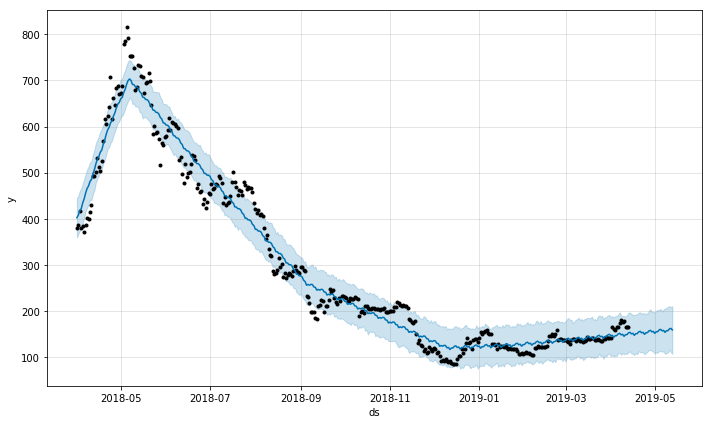

In [36]:
# displaying the plot
fig1

While the default plot method is helpful, it [does not make it easy](https://github.com/facebook/prophet/issues/133) to view just a small subet of the chart (e.g. if you wanted to limit your view to the last handful of months). In order to deal with this, I have written a custom helper function [that you can find on GitHub here](https://github.com/pmaji/data-science-toolkit/blob/master/time-series/prophet_helper_functions.py), which I now prefer to use for all my forecast plotting. It behaves identically to the base Prophet plot method, with a few additional functionalities:

- added parameter so you can specify what x-axis date format you want
- added parameter so you can specify the first date to include in the plot
- added parameter so you can specify the last date to include in the plot
- added parameter so you can specify if you want the x-axis labels auto-fit & rotated or not

In [37]:
# sourcing the file containing my custom plotting function
%run -i 'prophet_helper_functions.py'

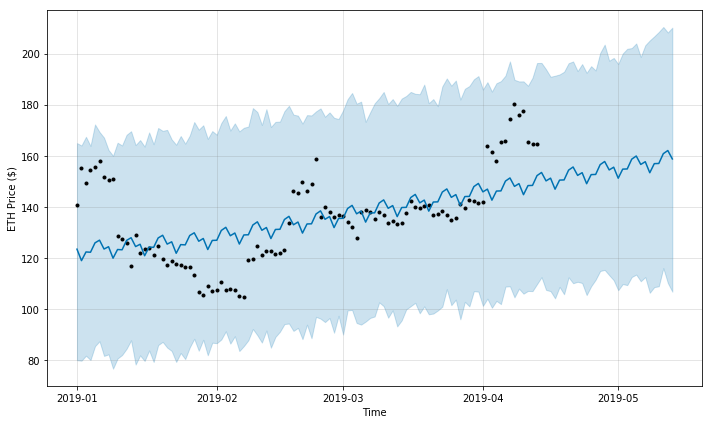

In [38]:
# plotting the fit and forecast for January - June 1st 2019
dt_restricted_prophet_plt(
    m = m,
    fcst = forecast,
    visible_window_start_dt = '01JAN2019',
    visible_window_end_dt = '01JUNE2019',
    ylabel = "ETH Price ($)",
    xlabel = "Time",
    x_axis_date_format = '%Y-%m',
    auto_fit_xaxis_labels = False
);

## Visualizing the Forecast's Components

Recall that Prophet is an additive model, so the final forecast is essentially composed of the modeled effects of various seasonalities, plus some non-seasonal trend. It is thus possible to deconstruct the forecast into its various components, and Prophet has a handy plot function to visualize precisely that. Below you will see 2 figures, each of which provides information about a particular model element. From the decomposition below of the various forecast components, we might surmise a couple of things (reading the charts top-to-bottom).

- From the 1st chart -- labeled "trend":
    - There is a discernable downwards trend in ETH's price that started around May of 2015, began to relax in its severity around September of 2018, and appears to have inverted (slightly) beginning just before 2019. 
- From the 2nd chart -- labeled "weekly":
    - There appears to be evidence here that **supports the viability of the weekend-bump hypothesis**. You can see this in that the weekly seasonality component of the model spikes highest on Saturday and Sunday, reaching its low-point on Wednesdays. Obviously a more robust model is needed to support the weekend-bump hypothesis with greater certainty, but Prophet is telling us that there might well be something about the weekends that has folks more bullish. 

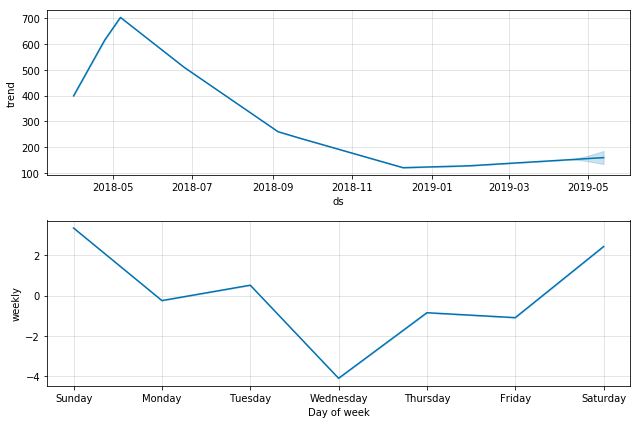

In [39]:
# plot of Prophet's decomposition of trend and seasonality
fig2 = m.plot_components(forecast)

## Model Diagnostics

Now that we have a forecast, the next question we must ask is obvious: "how good is it?"

There are a myriad of ways in which one might wish to answer the question of how well a time series forecasting model performs. Luckily, Prophet has a [series of built-in diagnostic tools](https://facebook.github.io/prophet/docs/diagnostics.html) that can be used to examine the robustness of the model. Below, I'll demonstrate Prophet's functionality for measuring forecast error using historical cross-validation. 

In [40]:
%%capture
# capturing warnings here because one of the dependencies throws a bunch of numpy deprecation warnings

from fbprophet.diagnostics import cross_validation

# we specify the forecast horizon to be used in the cv (here 30 days)
# the default initial training period is 3 times the horizon
# the default cutoffs are every 1/2 horizon
# all options are parameterized, see docs linked in cell above more info
df_cv = cross_validation(m, horizon = '30 days')

INFO:fbprophet:Making 18 forecasts with cutoffs between 2018-07-02 00:00:00 and 2019-03-14 00:00:00


In [41]:
# inspecting cross-validated results
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-07-03,418.768755,374.739317,464.185042,464.20,2018-07-02
1,2018-07-04,399.406512,352.980725,444.855872,467.32,2018-07-02
2,2018-07-05,411.014026,369.056031,455.703518,474.41,2018-07-02
3,2018-07-06,397.531018,350.363227,443.380777,474.01,2018-07-02
4,2018-07-07,401.746848,354.932709,449.874120,491.66,2018-07-02


The above table is similar to one we've already seen, with the exception being the addition of columns 'y' and 'cutoff'. 'y' here is simply the actual value observed for the price of ETH on the date 'ds', while 'cutoff' is the cutoff value used in that instance. As such, you can read the first row as follows:

When predicting a 30-day horizon using data up through July 2nd, 2018, this model predicted that the price of ETH one day after the cutoff date (i.e. the price on July 3rd) would be ~418.77, with an upper bound of ~467.06, and a lower bound of ~372.61. Given that the actual price on that date was 464.20, this forecast under-predicted the price of ETH on this date by ~45.43 (464.20-418.77). 

As you can see, it is thus quite easy to perform any residual-based calculations you might like using these cross-validated sets (more on this later). That said, let's take a look at just a few of the pre-packaged performance metrics that Prophet provides, below. 

In [42]:
from fbprophet.diagnostics import performance_metrics

# fetch a couple vanilla performance metrics
df_p = performance_metrics(df_cv)

In [43]:
# inspect the first 5 rows of diagnostic results
df_p.head(5)

,horizon,mse,rmse,mae,mape,coverage
32,3 days,1154.965840,33.984788,29.488339,0.150449,0.796296
453,4 days,1121.651120,33.491060,28.948481,0.151082,0.814815
363,4 days,1209.552109,34.778616,29.951428,0.157283,0.796296
513,4 days,1202.289795,34.674051,29.737222,0.155331,0.796296
93,4 days,1264.025762,35.553140,30.339535,0.158319,0.777778


The way to read the table above is as follows (look at the 1st row -- index 2):

When making cross-validated predictions with a horizon of 3 days, our mean absolute percent error (MAPE) was ~0.155. MAPE here is in decimals, so that translates to an average error of around %15.5. Depending on what your intended use case may be, that can either be very good, very bad, or somewhere in between. In my opinion, given what a noisy stochastic process the price of cryptocurrency presently is, I think that's a decent starting forecast. 

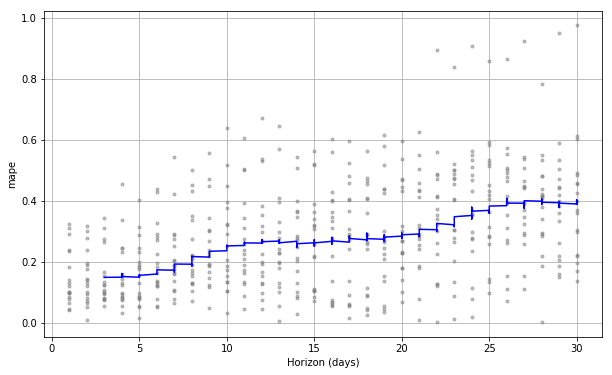

In [44]:
from fbprophet.plot import plot_cross_validation_metric

# now we plot a window-average for MAPE to see how the forecast performs
# the blue line represents the window-average MAPE, whereas the grey dots are individual observations
# for example, the top-right-most grey dot represents a single observation where the %error was nearly 100%
fig = plot_cross_validation_metric(df_cv, metric = 'mape')

I find that the chart above is quite helpful for examining the forecast's performance over different windows. For example, from the above figure, we can tell that the forecast gets progressively worse (going from < %20 MAPE up to ~ %30 MAPE) when you go from a horizon of 5 days to a horizon of 10 days. That said, looking beyond a 10 day horizon, it appears to do just as well forecasting 20 days as it does forecasting 10 days of prices, with further model degradation kicking it once your horizon goes above 20 days. 

Obviously, there are many more ways than this to look at the quality of your model. I have only delved into one of the Prophet-provided metrics here--MAPE--and there are others (MSE, RMSE, MAE, coverage) that warrant examination. In addition, you might wish to code up your own diagnostic metrics, perhaps involving the residuals. Below I'll show a very quick way of beginning to do just that, by looking at absolute residuals and percent error.

In [45]:
# calculating residuals manually
df_cv['residuals'] = abs(df_cv['y'] - df_cv['yhat'])

# calculating absolute percent error for each observation
df_cv['perc_error'] = df_cv['residuals']/df_cv['y']*100

In [46]:
# taking a look at some summary stats
df_cv.describe()

,yhat,yhat_lower,yhat_upper,y,residuals,perc_error
count,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000
mean,180.737765,127.833951,234.109768,201.690352,53.281437,28.378387
std,109.577081,109.883869,109.958727,103.572590,38.113534,17.580499
min,53.976666,-7.584384,110.587551,84.310000,0.499052,0.428077
25%,98.717194,47.792263,151.791940,127.550000,26.703895,13.557398
50%,137.795303,85.325753,193.233310,165.120000,46.158058,26.800662
75%,205.458878,153.230148,257.995364,228.107500,69.524509,40.688737
max,450.658091,409.545067,504.786793,501.000000,191.938208,97.553104


From the summary statistics above, we can see a couple of quick things of note.

- The average residual for our predictions was 53.28
- That translates to an average percent error of %28.38
- Our best prediction was only off by 0.43%
- Our worst prediction was off by 97.55%
    - This is the grey dot I called out in the comments on the figure above
    
## Conclusions:

- As to the evaluation of this specific model, I'm not blown away, but I'm also not disappointed. From the MAPE stats and residual info shown above, this is right in the ballpark of what I would have expected for a vanilla time series model. Given how easy to use Prophet is, I think one would have to be happy with how much information we can glean from such a low-effort highly-interpretable model. It would be worth spending the time to try to make this model more robust (perhaps starting with making use of Prophet's MCMC implementation for parameter estimation) to see just how good we can make the model. 
- Prophet is a great tool for gettig started with time series forecasting, because it is very low-effort and the start-up costs are low. If you have a dataframe with dates and corresponding values, you can probably be up and running with a forecast in < 1 hour. Will it be a *good* forecast? Probably not, but that's why the team at Facebook has written extensive documentation so that you can make your forecasts incrementally more robust! My goal in sharing this, in addition to exploring the aforementioned "weekend bull" hypothesis, was mainly to make folks aware that this capacity exists, and to encourage others to take a crack at a forecast of their own!
- The are [plenty of instances](https://kourentzes.com/forecasting/2017/07/29/benchmarking-facebooks-prophet/) in which Prophet is by no means the most robust time series forecasting method out there.
- In terms of optimal use cases for Prophet, Facebook uses it to forecast trends that are generally monotonically increasing/decreasing (e.g. number of Facebook users) and not as inconsistent or irregular as, say, the price of ETH. (source: discussion with former data scientist at FB and contributor to Prophet)
    - If you want to see where Facebook themselves says Prophet excels in terms of use cases, [check out their release announcement here](https://research.fb.com/prophet-forecasting-at-scale/) and CTRL+F "Where Prophet Shines"
- There are many things to keep in mind when you are evaluaitng time series performance beyond what I've shown here:
    - You want to check for any auto-correlation in your residuals -- more [on this here](https://stats.stackexchange.com/questions/49265/whats-the-deal-with-autocorrelation).
    - The diagnostic metrics I showed are all pretty vanilla. One might want to craft their own metric suited for their use case, for example: percent of instances where the MAPE exceeded X%.
    - Many other things... again, I'm not a time series expert! If you have any additional caveats you think should absolutely be added, open an issue!

## Thanks for reading, and happy forecasting! 

